# Proyecto Final - Accidentes en USA

En este proyecto se va a utilizar un DataSet de accidentes en US y se va a buscar analizar la gravedad de los mismos, para eso primero vamos a limpiar los datos para poder analizarlos y los vamos a guardar en un indice de Elastic Search y por ultimo vamos a graficar los resultados

Debido a que el dataset es demasiado pesado no se va a subir al repositorio de git pero lo pueden descargar de este link:
[Dataset](https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents?select=US_Accidents_March23.csv)

## Integrantes

- Marco Sebastián Hernández Parada (21150984)
- Alan Arturo Martinez Castro (21151078)

## Repositorio de GitHub  

- https://github.com/RKCbas/BigData-Apuntes/tree/main/Proyecto%20Final

## Archivos necesarios

- US_Accidents_March23.csv
   - Es el [Dataset](https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents?select=US_Accidents_March23.csv) que contiene los datos de los accidentes
- ElasticSearchProvider.py 
   - Archivo realizado en clase que cuenta con funciones para la conexión con el servidor de elastic Search, se encuentra en el [repositorio de GitHub](https://github.com/RKCbas/BigData-Apuntes/tree/main/Proyecto%20Final)
- mapping.json 
   - mapping para los datos que se ingresan al servidor de Elastic Search, se encuentra en el [repositorio de GitHub](https://github.com/RKCbas/BigData-Apuntes/tree/main/Proyecto%20Final)

## Importar librerías a utilizar

In [8]:
from ElasticSearchProvider import ElasticSearchProvider
import json
import time
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datashader as ds
import datashader.transfer_functions as tf
from datashader.utils import export_image
from datashader.colors import Hot
import cartopy.crs as ccrs
import cartopy.feature as cfeature

## Limpiar datos

### Rutas de archivos

Debido a que vamos a acceder continuamente a varios archivos vamos a guardar las rutas de los mismos en variables

In [9]:
json_file_path = "Datos.json"
csv_file_path = "US_Accidents_March23.csv"
RESPONSE_LITERAL = "response: "
host = "http://localhost:9200"  # URL del servidor de ElasticSearch
index_name = "us-accidents_march23"  # Nombre del índice de ElasticSearch

### Datos RAW

este es un ejemplo de los datos antes hacerles modificaciones, según el catalogo que esta en linea ([link](https://smoosavi.org/datasets/us_accidents)) vamos a analizar los datos y pasarlos a algo mas legible

**RAW:**
```CSV
ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Street,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,,,0.01,Right lane blocked due to accident on I-70 Eastbound at Exit 41 OH-235 State Route 4.,I-70 E,Dayton,Montgomery,OH,45424,US,US/Eastern,KFFO,2016-02-08 05:58:00,36.9,,91.0,29.68,10.0,Calm,,0.02,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.92805900000001,-82.831184,,,0.01,Accident on Brice Rd at Tussing Rd. Expect delays.,Brice Rd,Reynoldsburg,Franklin,OH,43068-3402,US,US/Eastern,KCMH,2016-02-08 05:51:00,37.9,,100.0,29.65,10.0,Calm,,0.0,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Day
A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,,,0.01,Accident on OH-32 State Route 32 Westbound at Dela Palma Rd. Expect delays.,State Route 32,Williamsburg,Clermont,OH,45176,US,US/Eastern,KI69,2016-02-08 06:56:00,36.0,33.3,100.0,29.67,10.0,SW,3.5,,Overcast,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,Night,Day,Day
A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.20558199999998,,,0.01,Accident on I-75 Southbound at Exits 52 52B US-35. Expect delays.,I-75 S,Dayton,Montgomery,OH,45417,US,US/Eastern,KDAY,2016-02-08 07:38:00,35.1,31.0,96.0,29.64,9.0,SW,4.6,,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Day,Day,Day
A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,,,0.01,Accident on McEwen Rd at OH-725 Miamisburg Centerville Rd. Expect delays.,Miamisburg Centerville Rd,Dayton,Montgomery,OH,45459,US,US/Eastern,KMGY,2016-02-08 07:53:00,36.0,33.3,89.0,29.65,6.0,SW,3.5,,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,True,False,Day,Day,Day,Day
A-6,Source2,3,2016-02-08 07:44:26,2016-02-08 08:14:26,40.100590000000004,-82.92519399999998,,,0.01,Accident on I-270 Outerbelt Northbound near Exit 29 OH-3 State St. Expect delays.,Westerville Rd,Westerville,Franklin,OH,43081,US,US/Eastern,KCMH,2016-02-08 07:51:00,37.9,35.5,97.0,29.63,7.0,SSW,3.5,0.03,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
```

>Como se puede observar es complicado leer los datos en ese formato entonces vamos a limpiar y modificar los datos

### Cargar los datos en un csv

Lo primero que vamos a hacer es cargar los datos en data frame y ahi vamos a eliminar algunos datos que consideremos innecesarios y vamos a guardar en un json aleatoriamente 1´000,000 de registros para el análisis

In [ ]:
# cargamos los datos desde el csv
df = pd.read_csv(csv_file_path)

# vamos a eliminar las columnas que no nos interesan
df = df.drop(columns=["Airport_Code"])

# vamos a guardar 1_000_000 de registros aleatorios en el json
df = df.sample(1_000_000, random_state=1)
df.to_json(json_file_path, orient="records", lines=True)

### Redondear la distancia

In [4]:
# Redondear el campo "Distance(mi)" a 4 dígitos decimales
df = pd.read_json(json_file_path, lines=True, orient="records")

df["Distance(mi)"] = df["Distance(mi)"].round(4)

df.to_json(json_file_path, orient="records", lines=True)

### Darle formato a las fechas

In [ ]:
df = pd.read_json(json_file_path, lines=True, orient="records")

# Convertir las fechas al formato deseado sin los ceros adicionales
df["Start_Time"] = pd.to_datetime(df["Start_Time"], errors="coerce").dt.strftime("%Y-%m-%d %H:%M:%S")
df["End_Time"] = pd.to_datetime(df["End_Time"], errors="coerce").dt.strftime("%Y-%m-%d %H:%M:%S")

df.to_json(json_file_path, orient="records", lines=True)

### Formatear los datos para evitar errores

**Nota:** Cada que carguemos los datos se nos va a generar otra muestra de datos distinta debido a que agarramos una muestra aleatoria.

Como resultado obtenemos un json con un formato similar al siguiente:

```Json
{
  "ID": "A-3843722",
  "Source": "Source1",
  "Severity": 2,
  "Start_Time": "2023-01-27 23:53:28",
  "End_Time": "2023-01-28 01:16:30",
  "Start_Lat": 35.793736,
  "Start_Lng": -78.64394,
  "End_Lat": 35.795108,
  "End_Lng": -78.643711,
  "Distance(mi)": 0.096,
  "Description": "Incident on PIERCE ST near JEFFERSON ST Drive with caution.",
  "Street": " Adams St",
  "City": "Raleigh",
  "County": "Wake",
  "State": "NC",
  "Zipcode": "27605-1201",
  "Country": "US",
  "Timezone": "US/Eastern",
  "Weather_Timestamp": "2023-01-27 23:51:00",
  "Temperature(F)": 35.0,
  "Crossing": 30.0,
  "Humidity(%)": 59.0,
  "Pressure(in)": 29.86,
  "Visibility(mi)": 10.0,
  "Wind_Direction": "SSW",
  "Wind_Speed(mph)": 6.0,
  "Precipitation(in)": 0.0,
  "Weather_Condition": "Fair",
  "Amenity": false,
  "Bump": false,
  "Crossing": false,
  "Give_Way": false,
  "Junction": false,
  "No_Exit": false,
  "Railway": false,
  "Roundabout": false,
  "Station": false,
  "Stop": false,
  "Traffic_Calming": false,
  "Traffic_Signal": false,
  "Turning_Loop": false,
  "Sunrise_Sunset": "Night",
  "Civil_Twilight": "Night",
  "Nautical_Twilight": "Night",
  "Astronomical_Twilight": "Night"
},
{
  "ID": "A-3535146",
  "Source": "Source1",
  "Severity": 3,
  "Start_Time": "2016-11-07 08:04:45",
  "End_Time": "2016-11-07 14:04:45",
  "Start_Lat": 38.76415,
  "Start_Lng": -121.25732,
  "End_Lat": 38.7668,
  "End_Lng": -121.2535,
  "Distance(mi)": 0.275,
  "Description": "At Taylor Rd - Accident.",
  "Street": "I-80 E",
  "City": "Roseville",
  "County": "Placer",
  "State": "CA",
  "Zipcode": "95661",
  "Country": "US",
  "Timezone": "US/Pacific",
  "Weather_Timestamp": "2016-11-07 07:55:00",
  "Temperature(F)": 53.6,
  "Wind_Chill(F)": null,
  "Humidity(%)": 100.0,
  "Pressure(in)": 30.19,
  "Visibility(mi)": 9.0,
  "Wind_Direction": "Calm",
  "Wind_Speed(mph)": null,
  "Precipitation(in)": null,
  "Weather_Condition": "Clear",
  "Amenity": false,
  "Bump": false,
  "Crossing": false,
  "Give_Way": false,
  "Junction": true,
  "No_Exit": false,
  "Railway": false,
  "Roundabout": false,
  "Station": false,
  "Stop": false,
  "Traffic_Calming": false,
  "Traffic_Signal": false,
  "Turning_Loop": false,
  "Sunrise_Sunset": "Day",
  "Civil_Twilight": "Day",
  "Nautical_Twilight": "Day",
  "Astronomical_Twilight": "Day"
}
```
Afortunadamente de donde descargamos el dataset son muy claros por lo que no necesitan de modificaciones mayores entonces ahora vamos a proceder a diseñar el **mapping** para poder subir nuestros datos a **Elastic Search**

### Crear el **Mapping**

En base a los datos diseñamos un **mapping** con el siguiente formato:

```Json
{
  "mappings": {
    "properties": {
      "ID": { "type": "keyword" },
      "Source": { "type": "keyword" },
      "Severity": { "type": "integer" },
      "Start_Time": { "type": "date", "format": "yyyy-MM-dd HH:mm:ss", "null_value": null },
      "End_Time": { "type": "date", "format": "yyyy-MM-dd HH:mm:ss", "null_value": null },
      "Start_Lat": { "type": "float", "null_value": null },
      "Start_Lng": { "type": "float", "null_value": null },
      "End_Lat": { "type": "float", "null_value": null },
      "End_Lng": { "type": "float", "null_value": null },
      "Distance(mi)": { "type": "float", "null_value": -1 },
      "Description": { "type": "text" },
      "Street": { 
        "type": "text",
            "fields": {
              "keyword": {
                "type": "keyword",
                "ignore_above": 256
              }
            },
        "null_value": "Unknown"
      },
      "City": { 
        "type": "text",
            "fields": {
              "keyword": {
                "type": "keyword",
                "ignore_above": 256
              }
            },
        "null_value": "Unknown"
      },
      "County": { 
        "type": "text",
            "fields": {
              "keyword": {
                "type": "keyword",
                "ignore_above": 256
              }
            },
        "null_value": "Unknown"
      },
      "State": { "type": "keyword", "null_value": "Unknown" },
      "Zipcode": { "type": "keyword", "null_value": "00000" },
      "Country": { "type": "keyword", "null_value": "Unknown" },
      "Timezone": { "type": "keyword", "null_value": "Unknown" },
      "Weather_Timestamp": { "type": "date", "format": "yyyy-MM-dd HH:mm:ss", "null_value": null },
      "Temperature(F)": { "type": "float", "null_value": -9999 },
      "Wind_Chill(F)": { "type": "float", "null_value": -9999 },
      "Humidity(%)": { "type": "float", "null_value": -9999 },
      "Pressure(in)": { "type": "float", "null_value": -9999 },
      "Visibility(mi)": { "type": "float", "null_value": -9999 },
      "Wind_Direction": { "type": "keyword", "null_value": "Unknown" },
      "Wind_Speed(mph)": { "type": "float", "null_value": -9999 },
      "Precipitation(in)": { "type": "float", "null_value": -9999 },
      "Weather_Condition": { "type": "keyword", "null_value": "Unknown" },
      "Amenity": { "type": "boolean" },
      "Bump": { "type": "boolean" },
      "Crossing": { "type": "boolean" },
      "Give_Way": { "type": "boolean" },
      "Junction": { "type": "boolean" },
      "No_Exit": { "type": "boolean" },
      "Railway": { "type": "boolean" },
      "Roundabout": { "type": "boolean" },
      "Station": { "type": "boolean" },
      "Stop": { "type": "boolean" },
      "Traffic_Calming": { "type": "boolean" },
      "Traffic_Signal": { "type": "boolean" },
      "Turning_Loop": { "type": "boolean" },
      "Sunrise_Sunset": { "type": "keyword", "null_value": "Unknown" },
      "Civil_Twilight": { "type": "keyword", "null_value": "Unknown" },
      "Nautical_Twilight": { "type": "keyword", "null_value": "Unknown" },
      "Astronomical_Twilight": { "type": "keyword", "null_value": "Unknown" }
    }
  }
}

```

ahora vamos a proceder a cargar el mapping a Elastic Search pero primero vamos a comprobar la conexión a nuestro servidor de Elastic Search

## Cargar los datos

### Verificar conexión con Elastic Search

In [ ]:
try:
        es_handler = ElasticSearchProvider(index=index_name,)
        print("es_handler: ", es_handler, "\n")

        response = es_handler.show_all_indices()
        print(f"{RESPONSE_LITERAL} {json.dumps(response.body if hasattr(response, 'body') else response, indent=4)}\n")
        
except Exception as e:
        print(f"An error occurred: {e}")

es_handler:  <ElasticSearchProvider.ElasticSearchProvider object at 0x000001CEDEC1E180> 

response:  {
    ".internal.alerts-transform.health.alerts-default-000001": {
        "aliases": {
            ".alerts-transform.health.alerts-default": {
                "is_write_index": true
            }
        }
    },
    "us-accidents_march23": {
        "aliases": {}
    },
    ".slo-observability.sli-v3.3": {
        "aliases": {}
    },
    "my-index": {
        "aliases": {}
    },
    ".internal.alerts-ml.anomaly-detection.alerts-default-000001": {
        "aliases": {
            ".alerts-ml.anomaly-detection.alerts-default": {
                "is_write_index": true
            }
        }
    },
    ".internal.alerts-observability.slo.alerts-default-000001": {
        "aliases": {
            ".alerts-observability.slo.alerts-default": {
                "is_write_index": true
            }
        }
    },
    ".internal.alerts-default.alerts-default-000001": {
        "aliases": {

c:\Users\sebas\Documents\ITA\Semestre VIII\Big Data\Apuntes\Proyecto Final\ElasticSearchProvider.py:268: ElasticsearchWarning: this request accesses system indices: [.apm-custom-link, .kibana_usage_counters_8.17.1_001, .kibana_analytics_8.17.1_001, .kibana_8.17.1_001, .kibana_alerting_cases_8.17.1_001, .kibana_task_manager_8.17.1_001, .apm-agent-configuration, .security-7, .kibana_security_solution_8.17.1_001, .kibana_ingest_8.17.1_001], but in a future major version, direct access to system indices will be prevented by default
  response = self.connection.indices.get_alias(index="*")


>Descripción: Solo comprobamos la conexión con el constructor de la clase de ElasticSearchProvider() y le pasamos el nombre de nuestro indice

Constructor de ElasticSearchProvider:

```Python
def __init__(self, index="person"):
    self.host = "http://localhost:9200"
    #   self.user = str(user)
    #   self.password = str(password)
    self.index = index
    self.index_type = "_doc"
    # Configurar timeout, re-intentos y retry_on_timeout
    self.connection = Elasticsearch(
        self.host,
        timeout=30,  # Tiempo de espera en segundos
        max_retries=3,  # Número máximo de re-intentos
        retry_on_timeout=True  # Re-intentar si hay un timeout
    )
```

Función para mostrar los indices:

```Python
def show_all_indices(self):
    try:
        response = self.connection.indices.get_alias(index="*")
        if not response:
            return {
                "StatusCode": 404,
                "body": json.dumps({
                    "message": "No indices found"
                })
            }
        return response
    except Exception as e:
        return {
            "StatusCode": 500,
            "body": json.dumps({
                "message": str(e)
                })
        }
```

Ahora que comprobamos que tenemos conexión con nuestro servidor vamos a cargar el **mapping**

### Cargar el mapping


In [ ]:
try:
    with ElasticSearchProvider(index=index_name) as es:

        # Cargar el mapping desde el json
        mapping_file_path = "mapping.json"
        mapping_data = pd.read_json(mapping_file_path)
        mapping = mapping_data.to_dict()

        response = es.delete_index()
        print(f"{RESPONSE_LITERAL} {json.dumps(response.body if hasattr(response, 'body') else response, indent=4)}\n")

        response = es.create_index(mapping=mapping)
        print(f"{RESPONSE_LITERAL} {json.dumps(response.body if hasattr(response, 'body') else response, indent=4)}\n")

        time.sleep(2)

        response = es.get_mapping()
        print(f"{RESPONSE_LITERAL} {json.dumps(response.body if hasattr(response, 'body') else response, indent=4)}\n")
        
except Exception as e:
    print(f"an error occurred: {e}")

response:  {
    "acknowledged": true
}

response:  {
    "acknowledged": true,
    "shards_acknowledged": true,
    "index": "us-accidents_march23"
}

response:  {
    "us-accidents_march23": {
        "mappings": {
            "properties": {
                "Amenity": {
                    "type": "boolean"
                },
                "Astronomical_Twilight": {
                    "type": "keyword",
                    "null_value": "Unknown"
                },
                "Bump": {
                    "type": "boolean"
                },
                "City": {
                    "type": "keyword",
                    "null_value": "Unknown"
                },
                "Civil_Twilight": {
                    "type": "keyword",
                    "null_value": "Unknown"
                },
                "Country": {
                    "type": "keyword",
                    "null_value": "Unknown"
                },
                "County": {
                

>Descripción: Al ejecutar esto deberíamos de obtener una respuesta de que cargamos con éxito el mapping a nuestro indice y después lo consultamos

Función create_index(mapping) y get_mapping() de la clase ElasticSearchProvider:

```Python
def create_index(self, mapping):
    try:
        if not self.connection.indices.exists(index=self.index):
            response = self.connection.indices.create(index=self.index, body=mapping)
        else:
            response = {
                "StatusCode": 400,
                "body": json.dumps({
                    "message": f"Index {self.index} already exists"
                })
            }
        return response
    except Exception as e:
        return {
            "StatusCode": 500,
            "body": json.dumps({
                "message": str(e)
                })
        }

def get_mapping(self):
    try:
        response = self.connection.indices.get_mapping(index=self.index)
        return response
    except Exception as e:
        return {
            "StatusCode": 500,
            "body": json.dumps({
                "message": str(e)
                })
        }
```

### Cargar los datos a nuestro indice

In [ ]:
from elasticsearch import helpers
from elasticsearch.helpers import BulkIndexError
from elasticsearch import Elasticsearch, ConnectionError as ESConnectionError

try:
    index = index_name  # Nombre del índice de ElasticSearch

    connection = Elasticsearch(
        host,
        max_retries=3,  # Número máximo de re-intentos
        retry_on_timeout=True  # Re-intentar si hay un timeout
    )

    print(f"Loading JSON file: {json_file_path} into ElasticSearch...\n")
    
    # Verificar si el archivo existe
    if not os.path.isfile(json_file_path):
        raise FileNotFoundError(f"File not found: {json_file_path}")
    
    df = pd.read_json(json_file_path, lines=True, orient="records")
    
    df["Start_Time"] = df["Start_Time"].astype(str)
    df["End_Time"] = df["End_Time"].astype(str)

    # Convertir NaN a null
    df = df.where(pd.notnull(df), None)
    df = df.replace({np.nan: None}) 

    documents = df.to_dict(orient="records")

    batch_size = 10_000  # Tamaño del lote para la carga
    for i in range (0, len(documents), batch_size):
        batch = documents[i:i + batch_size]

        bulk_data = [
            {"_index": index, "_source": doc}
            for doc in batch
        ]
        
        try:
            helpers.bulk(connection, bulk_data)
        except BulkIndexError as e:
            for error in e.errors:
                print(f"Error al indexar documento: {error}")

    error = "Data loaded successfully into ElasticSearch.\n"

except ValueError as e:
    error = {
        "StatusCode": 400,
        "body": json.dumps({
            "message": f"Error reading JSON with pandas: {str(e)}"
        })
    }
except FileNotFoundError as e:
    error = {
        "StatusCode": 404,
        "body": json.dumps({
            "message": f"File not found: {str(e)}"
        })
    }
except ESConnectionError as e:
    error = {
        "StatusCode": 500,
        "body": json.dumps({
            "message": f"Connection error: {str(e)}"
        })
    }
except Exception as e:
    error = {
        "StatusCode": 500,
        "body": json.dumps({
            "message": f"An error occurred: {str(e)}"
        })
    }
print(error)

Con esto ya tenemos todos nuestros datos en Elastic Search, debido a que la conversion que se hace de df a directorio para ingresarlo a Elastic Search unos datos se pasan de la manera equivocada no pudimos utilizar nuestro provider y colocamos toda la función con sus modificaciones en la celda de arriba

### Verificar los datos insertados

Vamos a hacer una consulta para verificar que nuestros datos se ingresaran correctamente

In [16]:
try:
    with ElasticSearchProvider(index=index_name) as es:

        response = es.get_all_documents()

        print(f"{RESPONSE_LITERAL} {json.dumps(response.body if hasattr(response, 'body') else response, indent=4)}\n")

        
except Exception as e:
    print(f"an error occurred: {e}")

response:  {
    "took": 14,
    "timed_out": false,
    "_shards": {
        "total": 1,
        "successful": 1,
        "skipped": 0,
        "failed": 0
    },
    "hits": {
        "total": {
            "value": 10000,
            "relation": "gte"
        },
        "max_score": 1.0,
        "hits": [
            {
                "_index": "us-accidents_march23",
                "_id": "nioKF5YBnGOPUnCHV31P",
                "_score": 1.0,
                "_source": {
                    "ID": "A-3843722",
                    "Source": "Source1",
                    "Severity": 2,
                    "Start_Time": "2023-01-27 23:53:28",
                    "End_Time": "2023-01-28 01:16:30",
                    "Start_Lat": 35.793736,
                    "Start_Lng": -78.64394,
                    "End_Lat": 35.795108,
                    "End_Lng": -78.643711,
                    "Distance(mi)": 0.096,
                    "Description": "Incident on PIERCE ST near JEFFERSON ST 

Con esta consulta podemos obtener los primeros registros de nuestros datos del servidor de elastic search que se muestran en el formato que queríamos.

## Analizar los datos

Ahora vamos a proceder con el análisis de datos para lo que vamos a acceder a nuestros datos de Elastic Search para después presentar estos mismos en una gráfica

### Cantidad de accidentes por estado

response:  {
    "took": 1,
    "timed_out": false,
    "_shards": {
        "total": 1,
        "successful": 1,
        "skipped": 0,
        "failed": 0
    },
    "hits": {
        "total": {
            "value": 10000,
            "relation": "gte"
        },
        "max_score": null,
        "hits": []
    },
    "aggregations": {
        "states_count": {
            "doc_count_error_upper_bound": 0,
            "sum_other_doc_count": 0,
            "buckets": [
                {
                    "key": "CA",
                    "doc_count": 231073
                },
                {
                    "key": "FL",
                    "doc_count": 117286
                },
                {
                    "key": "TX",
                    "doc_count": 76955
                },
                {
                    "key": "SC",
                    "doc_count": 50262
                },
                {
                    "key": "NY",
                    "doc_count": 458

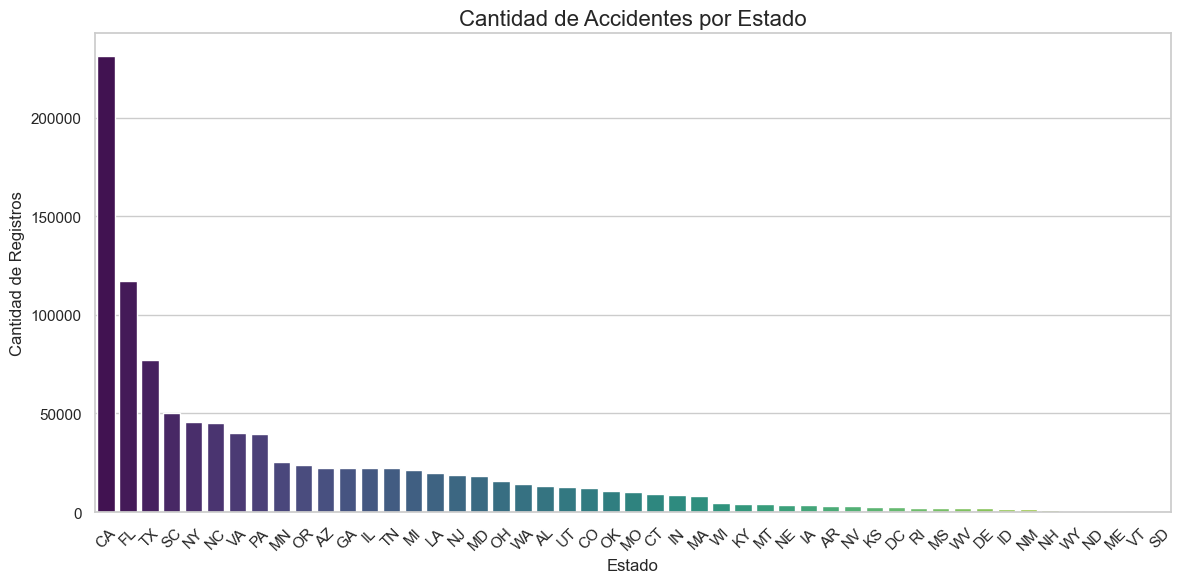

In [19]:
try:
    with ElasticSearchProvider(index=index_name) as es:

        response = es.search(
            query = {
                "size": 0,  # No queremos los documentos, solo la agregación
                "aggs": {
                    "states_count": {
                        "terms": {
                            "field": "State",
                            "size": 50
                        }
                    }
                }
            }
        )

        print(f"{RESPONSE_LITERAL} {json.dumps(response.body if hasattr(response, 'body') else response, indent=4)}\n")

        states = [bucket['key'] for bucket in response['aggregations']['states_count']['buckets']]
        counts = [bucket['doc_count'] for bucket in response['aggregations']['states_count']['buckets']]
        
        # Configurar estilo de Seaborn
        sns.set(style="whitegrid")

        # Crear figura
        plt.figure(figsize=(12, 6))
        sns.barplot(x=states, y=counts, palette="viridis", hue=states, legend=False)

        # Añadir etiquetas y título
        plt.title("Cantidad de Accidentes por Estado", fontsize=16)
        plt.xlabel("Estado")
        plt.ylabel("Cantidad de Registros")
        plt.xticks(rotation=45)

        # Mostrar la gráfica
        plt.tight_layout()
        plt.show()
        
except Exception as e:
    print(f"an error occurred: {e}")

---

### Modificación durante la exposición

Durante la exposición se nos solicito también listar la cantidad de accidentes por estado para ver si los estados que se mostraban pertenecían a los estados con mayor cantidad de accidentes

- Resultado:

response:  {
    "took": 3,
    "timed_out": false,
    "_shards": {
        "total": 1,
        "successful": 1,
        "skipped": 0,
        "failed": 0
    },
    "hits": {
        "total": {
            "value": 10000,
            "relation": "gte"
        },
        "max_score": null,
        "hits": []
    },
    "aggregations": {
        "city_count": {
            "doc_count_error_upper_bound": 0,
            "sum_other_doc_count": 684178,
            "buckets": [
                {
                    "key": "Miami",
                    "doc_count": 24702
                },
                {
                    "key": "Houston",
                    "doc_count": 22215
                },
                {
                    "key": "Los Angeles",
                    "doc_count": 20678
                },
                {
                    "key": "Charlotte",
                    "doc_count": 18301
                },
                {
                    "key": "Dallas",
       

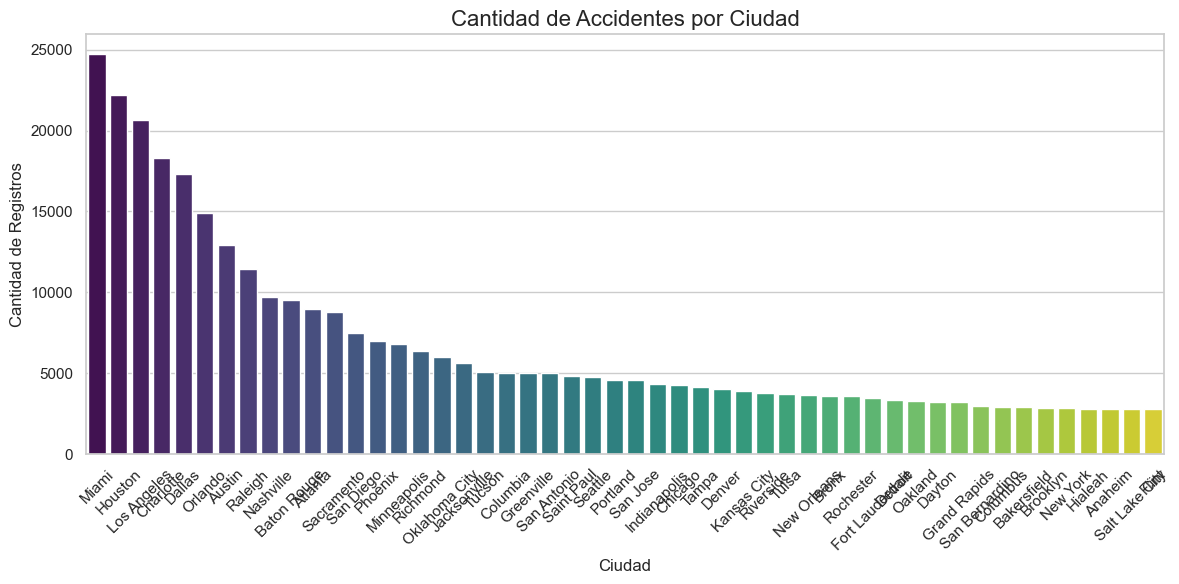

In [ ]:
try:
    with ElasticSearchProvider(index=index_name) as es:

        response = es.search(
            query = {
                "size": 0,  # No queremos los documentos, solo la agregación
                "aggs": {
                    "city_count": {
                        "terms": {
                            "field": "City",
                            "size": 50
                        }
                    }
                }
            }
        )

        print(f"{RESPONSE_LITERAL} {json.dumps(response.body if hasattr(response, 'body') else response, indent=4)}\n")

        cities = [bucket['key'] for bucket in response['aggregations']['city_count']['buckets']]
        counts = [bucket['doc_count'] for bucket in response['aggregations']['city_count']['buckets']]
        
        # Configurar estilo de Seaborn
        sns.set(style="whitegrid")

        # Crear figura
        plt.figure(figsize=(12, 6))
        sns.barplot(x=cities, y=counts, palette="viridis", hue=cities, legend=False)

        # Añadir etiquetas y título
        plt.title("Cantidad de Accidentes por Ciudad", fontsize=16)
        plt.xlabel("Ciudad")
        plt.ylabel("Cantidad de Registros")
        plt.xticks(rotation=45)

        # Mostrar la gráfica
        plt.tight_layout()
        plt.show()
        
except Exception as e:
    print(f"an error occurred: {e}")

#### California
   - Los Angeles - 20,678
   - Sacramento - 8,787
   - San Diego - 7,503
   - San Jose - 4,570
   - Riverside - 3,796
   - Oakland - 3,306
   - San Bernardino - 2,959
   - Bakersfield - 2,895
   - Anaheim - 2,795

### Texas
   - Houston – 22,215
   - Dallas – 17,333
   - Austin – 12,939
   - San Antonio – 4,991

### Florida
   - Miami – 24,702
   - Orlando – 14,904
   - Jacksonville – 5,605
   - Tampa – 4,140
   - Fort Lauderdale – 3,480
   - Hialeah – 2,809

Con esta consulta obtuvimos los 50 estados con mayor cantidad de accidentes y podemos ver que la mayoría de estos pertenecen a estos estados **(CA, TX, FL)**, lo que coincide con nuestra consulta anterior

---
### Mapa de calor de accidentes

C:\Users\sebas\AppData\Local\Temp\ipykernel_34228\2302113709.py:13: DeprecationWarning: Received 'size' via a specific parameter in the presence of a 'body' parameter, which is deprecated and will be removed in a future version. Instead, use only 'body' or only specific parameters.
  response = es.search(
c:\Users\sebas\Documents\ITA\Semestre VIII\Big Data\Apuntes\.venv\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
c:\Users\sebas\Documents\ITA\Semestre VIII\Big Data\Apuntes\.venv\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
c:\Users\sebas\Documents\ITA\Semestre VIII\Big Data\Apuntes\.venv\Lib\site-packages\cartopy\io\__init__.py:241: Do

Map image saved as 'mapa_accidentes_usa.png'


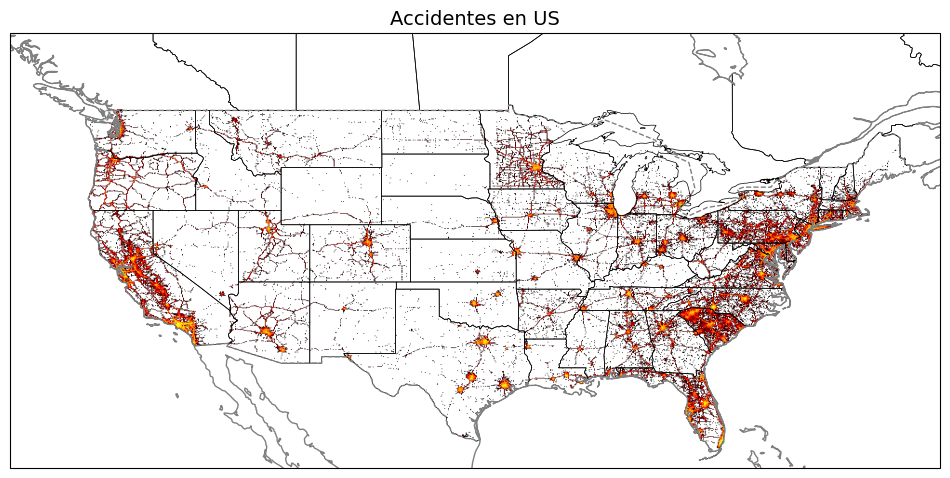

In [ ]:
from elasticsearch import Elasticsearch

try:

    with Elasticsearch(host) as es:

        # Scroll para traer muchos documentos 
        scroll_size = 5000
        all_coords = []

        response = es.search(
            index=index_name,
            scroll='2m',
            size=scroll_size,
            _source=["Start_Lat", "Start_Lng"],
            body={
                "query": {
                    "bool": {
                        "must": [
                            { "exists": { "field": "Start_Lat" } },
                            { "exists": { "field": "Start_Lng" } }
                        ]
                    }
                }
            }
        )
        
        scroll_id = response['_scroll_id']
        hits = response['hits']['hits']

        while hits and len(all_coords) < 995_000:
            for hit in hits:
                src = hit['_source']
                lat = src.get('Start_Lat')
                lng = src.get('Start_Lng')
                if lat is not None and lng is not None:
                    all_coords.append((lng, lat))   # (x, y) = (long, lat)

            response = es.scroll(scroll_id=scroll_id, scroll='2m')
            scroll_id = response['_scroll_id']
            hits = response['hits']['hits']

        es.clear_scroll(scroll_id=scroll_id)

        # Convertir a DataFrame
        df = pd.DataFrame(all_coords, columns=['x', 'y'])

        # Crear un canvas (área de dibujo)
        canvas = ds.Canvas(plot_width=1000, plot_height=600, x_range=[-130, -65], y_range=[24, 50])  # Territorio de USA
        agg = canvas.points(df, 'x', 'y')

        # Convertir agregación en imagen
        img = tf.shade(agg, cmap=Hot, how='log')

        # Convertir a imagen PIL
        img_pil = img.to_pil()

        # Dibujar sobre Cartopy
        fig = plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=ccrs.PlateCarree())
        ax.set_extent([-130, -65, 24, 50])  # Territorio de USA

        # Mostrar la imagen de datashader como fondo
        ax.imshow(img_pil, extent=[-130, -65, 24, 50], origin='upper')

        # Añadir contorno de estados
        ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
        ax.add_feature(cfeature.BORDERS, edgecolor='gray', linestyle='--')
        ax.add_feature(cfeature.COASTLINE, edgecolor='gray')

        # Mostrar imagen
        # img.to_pil().show()

        # export_image(img, filename="accidents_map")

        ax.set_title("Accidentes en US", fontsize=14)
        plt.savefig("mapa_accidentes_usa.png", dpi=300, bbox_inches='tight')
        print("Map image saved as 'mapa_accidentes_usa.png'")
        # plt.savefig("mapa_accidentes_usa.pdf")
        # plt.savefig("mapa_accidentes_usa.svg")

        
except Exception as e:
    print(f"an error occurred: {e}")

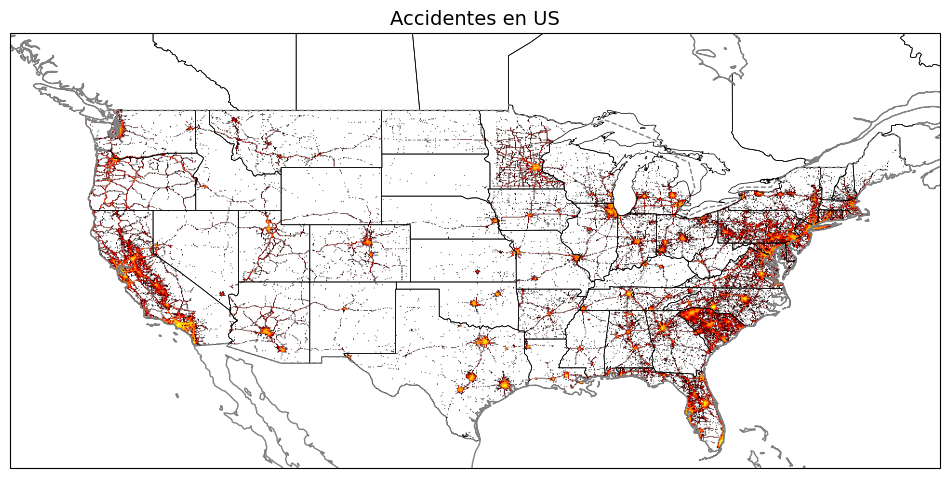

Este es un mapa de calor que nos muestra donde es que se concentran los accidentes en US

### Condiciones del clima en accidentes

C:\Users\sebas\AppData\Local\Temp\ipykernel_19008\1516528869.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=labels, palette="Blues_d")


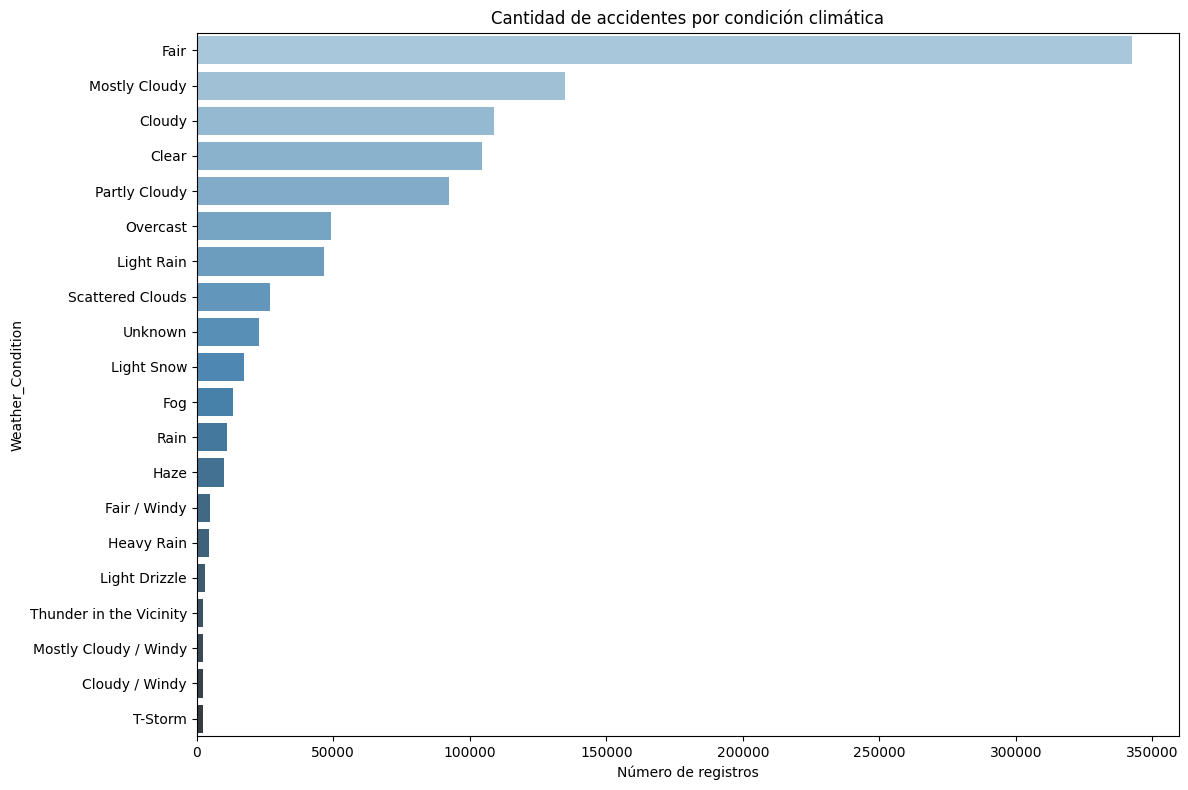

In [5]:
from elasticsearch import Elasticsearch

try:

    with Elasticsearch(host) as es:

        query = {
            "size": 0,  # no necesitamos documentos, solo agregaciones
            "aggs": {
                "weather_conditions": {
                    "terms": {
                        "field": "Weather_Condition",
                        "size": 20, # cantidad de tipos
                        "order": {
                            "_count": "desc"
                        }
                    }
                }
            }
        }

        response = es.search(index=index_name, body=query)

        # Parsear resultados
        weather_data = response['aggregations']['weather_conditions']['buckets']
        labels = [bucket['key'] for bucket in weather_data]
        counts = [bucket['doc_count'] for bucket in weather_data]   
        
        plt.figure(figsize=(12, 8))
        sns.barplot(x=counts, y=labels, palette="Blues_d")

        plt.title("Cantidad de accidentes por condición climática")
        plt.xlabel("Número de registros")
        plt.ylabel("Weather_Condition")
        plt.tight_layout()
        plt.show()

    
except Exception as e:
    print(f"an error occurred: {e}")

Con obtenemos los 20 climas en donde se presentan mas accidentes donde podemos observar que en "Fair" o soleado es donde se produjeron mas accidentes

### Histograma de visibilidad y accidentes

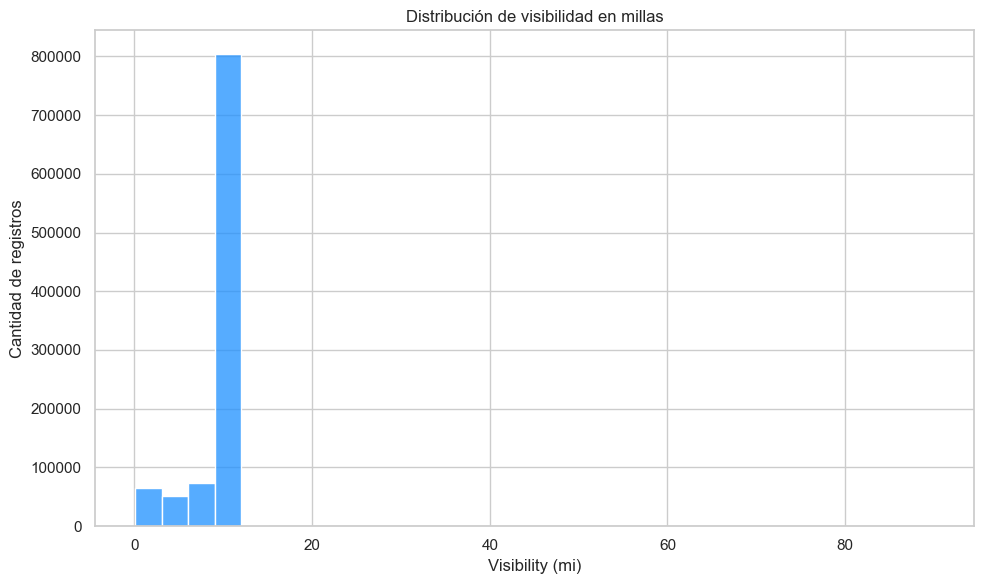

In [ ]:
from elasticsearch import Elasticsearch, helpers
try:
    with Elasticsearch(host) as es:

        query = {
            "_source": ["Visibility(mi)"],
            "query": {
                "exists": {"field": "Visibility(mi)"}
            }
        }

        # Recolección de datos con scan (scroll)
        results = helpers.scan(
            client=es,
            query=query,
            index=index_name,
            scroll="2m",
            size=5000 
        )

        # Convertimos a DataFrame
        data = [doc["_source"] for doc in results]
        df = pd.DataFrame(data)

        # Quitamos valores inválidos o nulos
        df = df[df["Visibility(mi)"] > 0]
        df = df[df["Visibility(mi)"] < 100]

        plt.figure(figsize=(10, 6))
        sns.histplot(
            data=df,
            x="Visibility(mi)",
            bins=30,
            color="dodgerblue"
        )

        plt.title("Distribución de visibilidad en millas")
        plt.xlabel("Visibility (mi)")
        plt.ylabel("Cantidad de registros")
        plt.tight_layout()
        plt.show()

        
except Exception as e:
    print(f"an error occurred: {e}")

### Correlación de variables

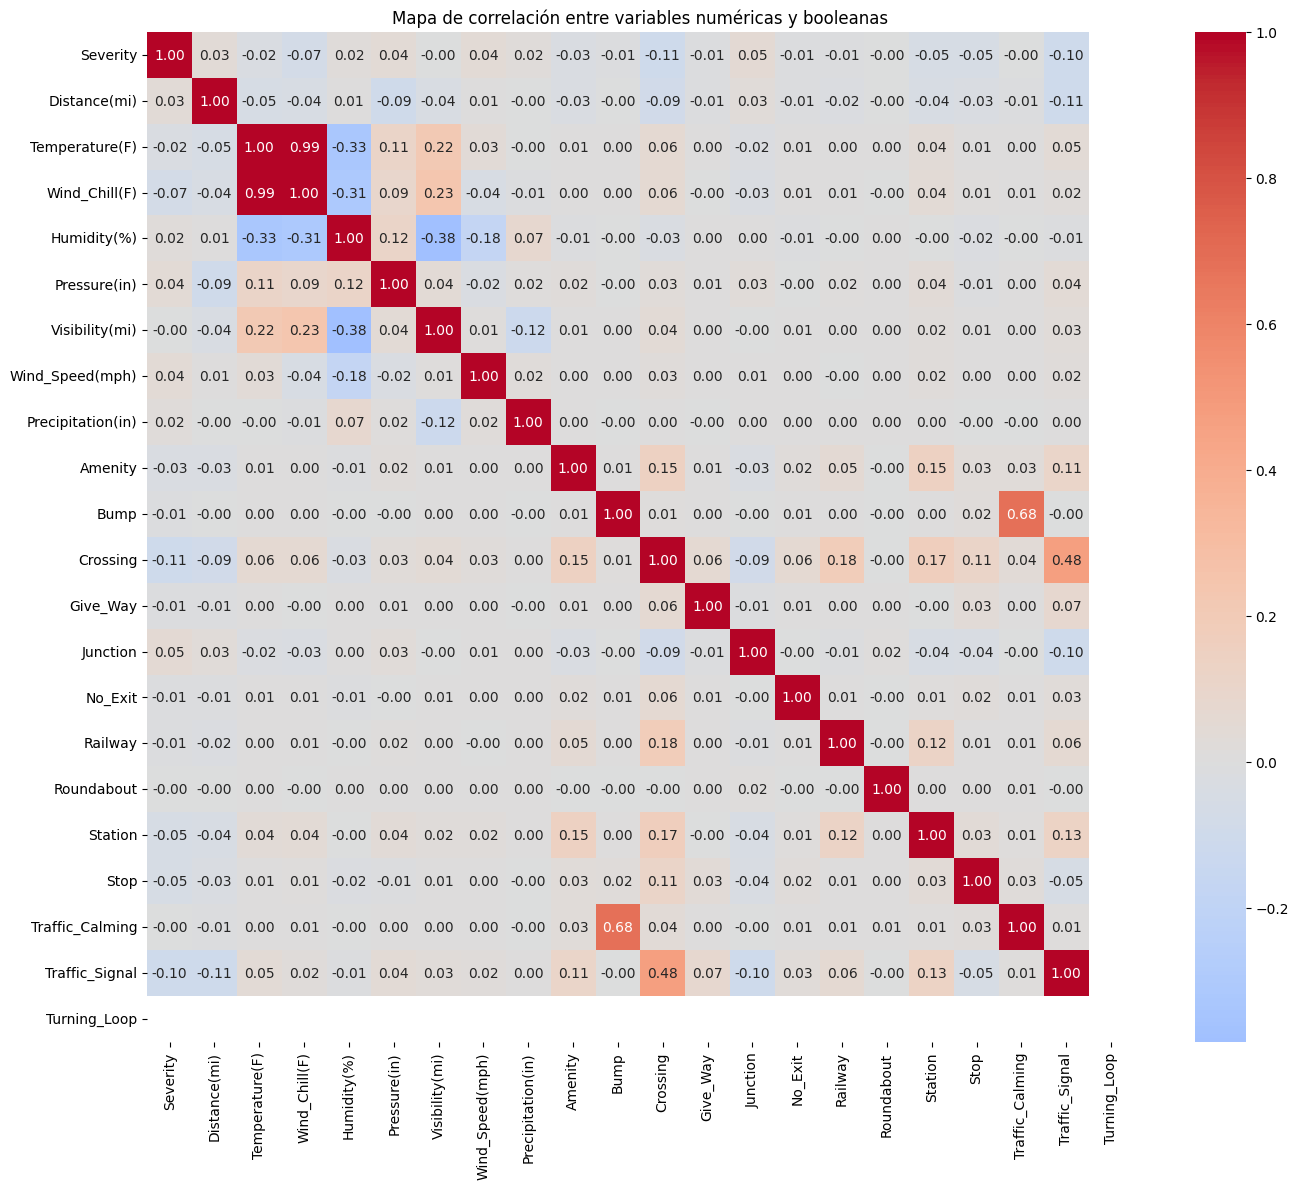

In [ ]:
from elasticsearch import Elasticsearch
try:
    with Elasticsearch(host) as es:

        # Vamos a consultar variables numéricas debido a que solo podemos analizar la correlación de variables numéricas
        fields = [
            "Severity", "Distance(mi)", "Temperature(F)", "Wind_Chill(F)",
            "Humidity(%)", "Pressure(in)", "Visibility(mi)", "Wind_Speed(mph)",
            "Precipitation(in)", "Amenity", "Bump", "Crossing", "Give_Way",
            "Junction", "No_Exit", "Railway", "Roundabout", "Station", "Stop",
            "Traffic_Calming", "Traffic_Signal"
        ]

        results = []
        
        # Scroll para obtener 10,000 documentos a la vez
        scroll = es.search(
            index=index_name, 
            body={
                "_source": fields,
                "size": 10000,
                "query": {
                    "exists": {
                        "field": f"{fields[0]}"
                        }
                    }
                }, 
            scroll="2m"
            )

        scroll_id = scroll['_scroll_id']
        hits = scroll['hits']['hits']

        while hits:
            for hit in hits:
                results.append(hit['_source'])

            # Realizar la petición para la siguiente página de resultados
            scroll = es.scroll(scroll_id=scroll_id, scroll='2m')
            scroll_id = scroll['_scroll_id']
            hits = scroll['hits']['hits']

        es.clear_scroll(scroll_id=scroll_id)

        # Crear DataFrame
        df = pd.DataFrame(results)
        
        # Calcular la correlación
        corr = df.corr(numeric_only=True)

        plt.figure(figsize=(14, 12))
        sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
        plt.title("Mapa de correlación entre variables numéricas y booleanas")
        plt.tight_layout()

        # Guardar como imagen
        plt.savefig('mapa_correlación.png', dpi=300)

        # Mostrar el gráfico
        plt.show()

except Exception as e:
    print(f"an error occurred: {e}")

Correlación:

 - Mide la fuerza y la dirección de la relación entre dos variables. Va de -1 a +1:

    - +1: Correlación positiva perfecta (cuando una variable aumenta, la otra también lo hace).

    - -1: Correlación negativa perfecta (cuando una variable aumenta, la otra disminuye).

    - 0: Sin correlación (no hay relación entre las dos variables).

Aquí se nos presenta el mapa de correlación de nuestras variables

### Gráfica de pastel del porcentaje de severidad y casos de severidad

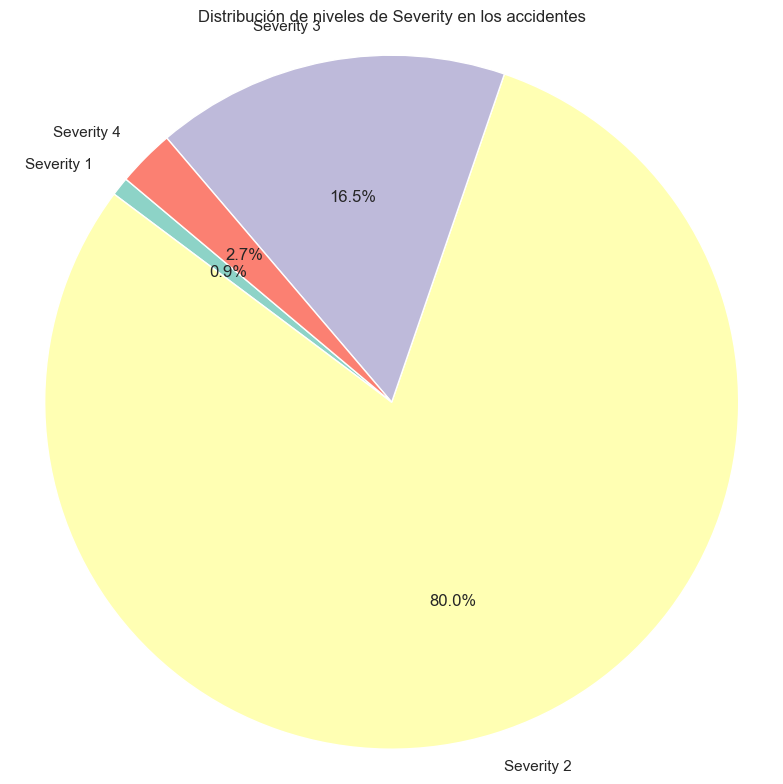

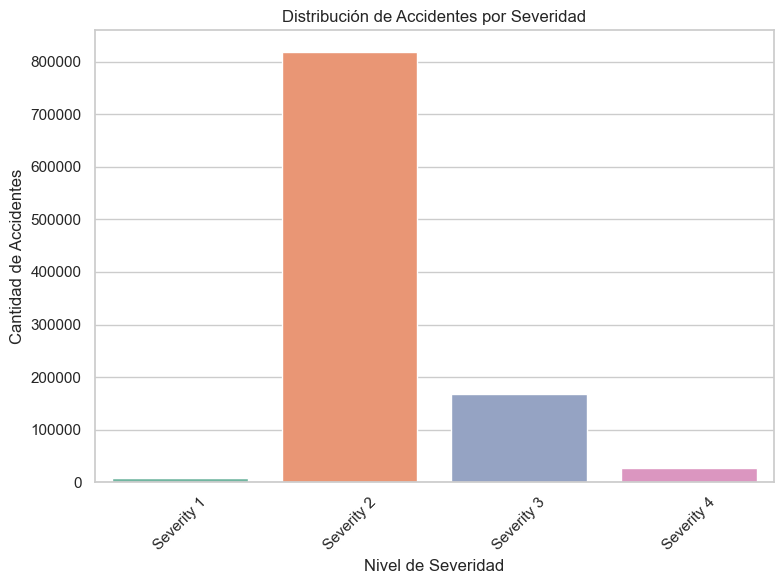

In [ ]:
from elasticsearch import Elasticsearch
try:
    with Elasticsearch(host) as es:

        # Consulta para contar por cada nivel de Severidad
        query = {
            "size": 0,
            "aggs": {
                "severity_counts": {
                    "terms": {
                        "field": "Severity",
                        "size": 5,
                        "order": {
                            "_key": "asc"
                        }
                    }
                }
            }
        }

        response = es.search(index=index_name, body=query)

        # Extraer los resultados
        buckets = response["aggregations"]["severity_counts"]["buckets"]
        labels = [f"Severity {bucket['key']}" for bucket in buckets]
        counts = [bucket["doc_count"] for bucket in buckets]


        plt.figure(figsize=(8, 8))
        colors = plt.cm.Set3.colors  # paleta de colores
        plt.pie(counts, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
        plt.title("Distribución de niveles de Severity en los accidentes")
        plt.axis('equal')  # hace que el pastel se vea como un círculo
        plt.tight_layout()
        plt.show()

        # Crear un DataFrame para facilitar el gráfico
        df_severity = pd.DataFrame({
            "Severity": labels,
            "Cantidad": counts
        })

        # Estilo
        sns.set(style="whitegrid")

        plt.figure(figsize=(8, 6))
        sns.barplot(
            x="Severity",
            y="Cantidad",
            data=df_severity,
            hue="Severity",
            palette="Set2",
            legend=False
        )

        # Etiquetas
        plt.title("Distribución de Accidentes por Severidad")
        plt.xlabel("Nivel de Severidad")
        plt.ylabel("Cantidad de Accidentes")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

except Exception as e:
    print(f"an error occurred: {e}")

### Relación entre Wind Chill (Sensación Térmica) y Severity (Severidad)

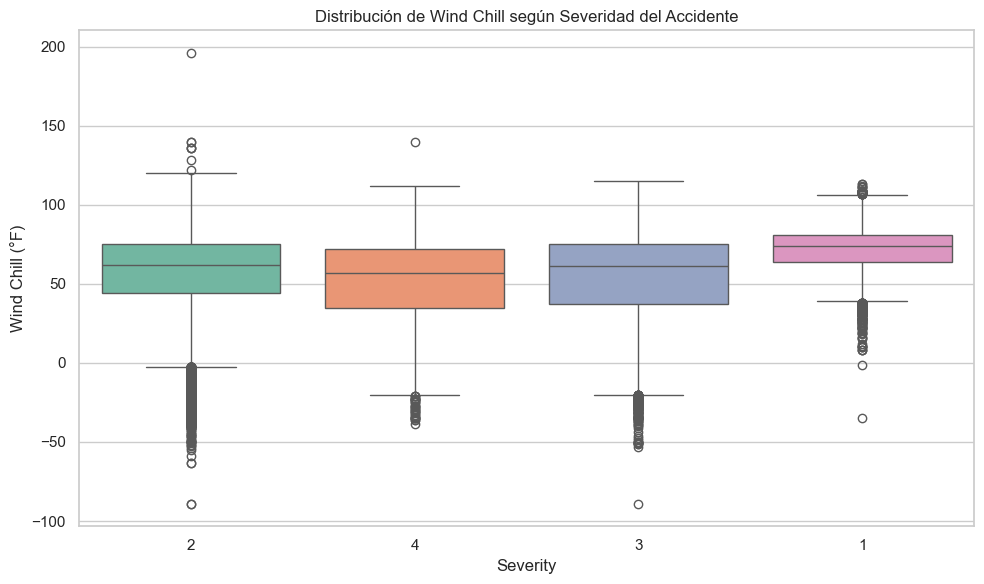

In [ ]:
from elasticsearch import Elasticsearch, helpers
try:
    with Elasticsearch(host) as es:

        # Definir la query base
        query = {
            "_source": ["Wind_Chill(F)", "Severity"],
            "query": {
                "bool": {
                    "must": [
                        {"exists": {"field": "Wind_Chill(F)"}},
                        {"exists": {"field": "Severity"}},
                        {"range": {"Wind_Chill(F)": {"gt": -100}}}  # filtra los null_value = -9999
                    ]
                }
            }
        }

        # Usar scan para manejar todos los documentos (más eficiente que scroll normal)
        results = helpers.scan(
            client=es,
            index=index_name,
            query=query,
            preserve_order=False,
            size=5000,
            scroll="2m"
        )

        # Convertir a DataFrame
        docs = list(results)
        data = [doc["_source"] for doc in docs]
        df = pd.DataFrame(data)

        df = df.dropna()
        df["Severity"] = df["Severity"].astype(str)  # para que seaborn lo trate como categoría

        plt.figure(figsize=(10, 6))
        sns.boxplot(
            x="Severity",
            y="Wind_Chill(F)",
            data=df,
            hue="Severity",
            palette="Set2",
            legend=False,
        )

        plt.title("Distribución de Wind Chill según Severidad del Accidente")
        plt.xlabel("Severity")
        plt.ylabel("Wind Chill (°F)")
        plt.tight_layout()
        plt.show()
        

except Exception as e:
    print(f"an error occurred: {e}")

>Nota: 32°F = 0°C, (32 °F − 32) × 5/9 = 0 °C

Partes del diagrama de caja

 - Línea central: Indica la mediana, que divide los datos en dos mitades iguales 
 - Caja: Indica el rango del 50% central de los datos 
 - Bigotes: Líneas que se extienden desde la caja y representan la varianza esperada de los datos 
 - Puntos fuera de los bigotes: Se consideran valores atípicos 

### Diagrama de violin de la severity (severidad) con amenity (amenidades)

Las amenidades son servicios o instalaciones adicionales que mejoran la experiencia y comodidad en un lugar, como un edificio de apartamentos, un hotel o un desarrollo inmobiliario. 

En nuestro caso se maneja entre si había amenidades cerca o no del lugar del accidente 

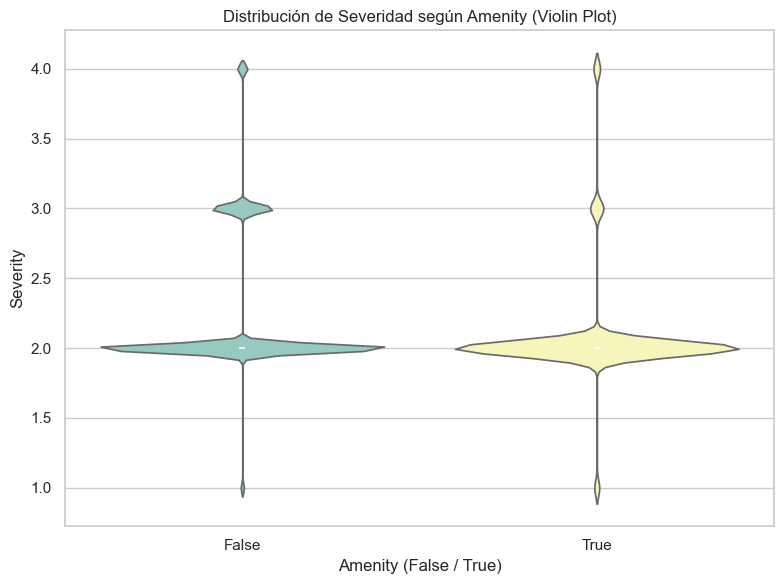

In [ ]:
from elasticsearch import Elasticsearch, helpers
try:
    with Elasticsearch(host) as es:

        # Consulta base
        query = {
            "_source": ["Amenity", "Severity"],
            "query": {
                "bool": {
                    "must": [
                        {"exists": {"field": "Amenity"}},
                        {"exists": {"field": "Severity"}}
                    ]
                }
            }
        }

        # Obtener todos los registros
        results = helpers.scan(
            client=es,
            index=index_name,
            query=query,
            preserve_order=False,
            size=5000,
            scroll="2m"
        )

        # Convertir a DataFrame
        docs = list(results)
        data = [doc["_source"] for doc in docs]
        df = pd.DataFrame(data)

        # Asegurar tipos correctos
        df.dropna(inplace=True)
        df = df[df["Severity"] > 0]  # eliminar posibles registros inválidos
        df["Amenity"] = df["Amenity"].astype(str)
        df["Severity"] = df["Severity"].astype(int)

        sns.set(style="whitegrid")

        plt.figure(figsize=(8, 6))
        sns.violinplot(
            x="Amenity",
            y="Severity",
            data=df,
            hue="Amenity",
            palette="Set3",
            inner="box",  # agrega un boxplot dentro
            legend=False
        )

        plt.title("Distribución de Severidad según Amenity (Violin Plot)")
        plt.xlabel("Amenity (False / True)")
        plt.ylabel("Severity")
        plt.tight_layout()
        plt.show()

except Exception as e:
    print(f"an error occurred: {e}")

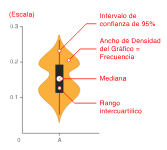

### Diagrama de violin entre Wind Chill (Sensación Térmica) y Severity (Severidad)

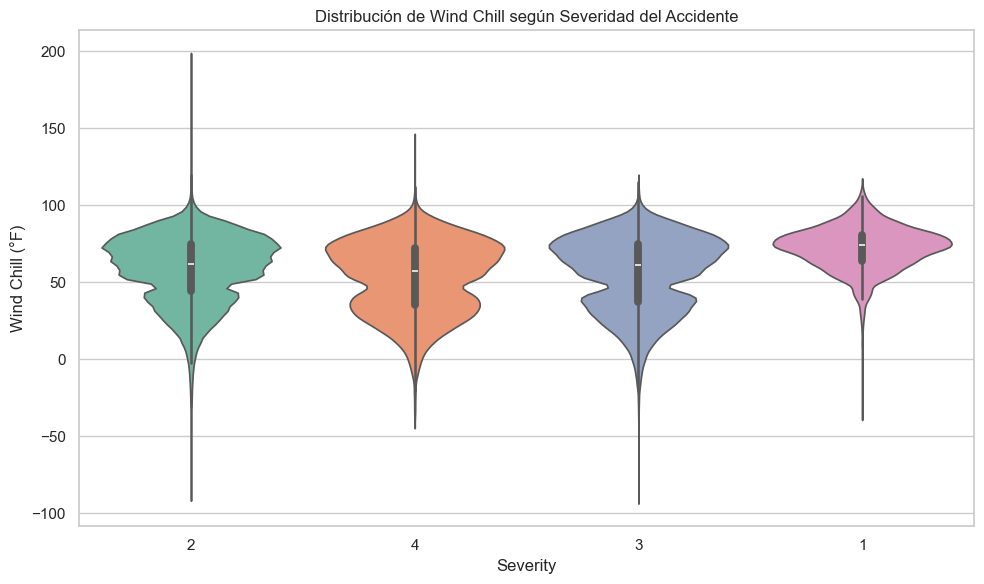

In [ ]:
from elasticsearch import Elasticsearch, helpers
try:
    with Elasticsearch(host) as es:

        query = {
            "_source": ["Severity", "Wind_Chill(F)"],
            "query": {
                "bool": {
                    "must": [
                        {"exists": {"field": "Severity"}},
                        {"exists": {"field": "Wind_Chill(F)"}},
                        {"range": {"Wind_Chill(F)": {"gt": -100}}}  # excluye valores nulos codificados como -9999
                                                                    # gt = greater than
                    ]
                }
            }
        }

        # Obtener todos los documentos
        results = helpers.scan(
            client=es,
            index=index_name,
            query=query,
            preserve_order=False,
            size=5000,
            scroll="2m"
        )

        # Convertir a DataFrame
        docs = list(results)
        data = [doc["_source"] for doc in docs]
        df = pd.DataFrame(data)

        df.dropna(inplace=True)
        df = df[df["Wind_Chill(F)"] > -100]  # seguridad adicional
        df["Severity"] = df["Severity"].astype(str)  # para que seaborn lo trate como categoría


        sns.set(style="whitegrid")

        plt.figure(figsize=(10, 6))
        sns.violinplot(
            x="Severity",
            y="Wind_Chill(F)",
            data=df,
            hue="Severity",
            palette="Set2",
            inner="box",
            legend=False
        )

        plt.title("Distribución de Wind Chill según Severidad del Accidente")
        plt.xlabel("Severity")
        plt.ylabel("Wind Chill (°F)")
        plt.tight_layout()
        plt.show()


except Exception as e:
    print(f"an error occurred: {e}")

>Nota: 32°F = 0°C, (32 °F − 32) × 5/9 = 0 °C

### Diagrama de violin entre crossing (Zebras o cruces) y severity (Severidad)

C:\Users\sebas\AppData\Local\Temp\ipykernel_23688\4157288274.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


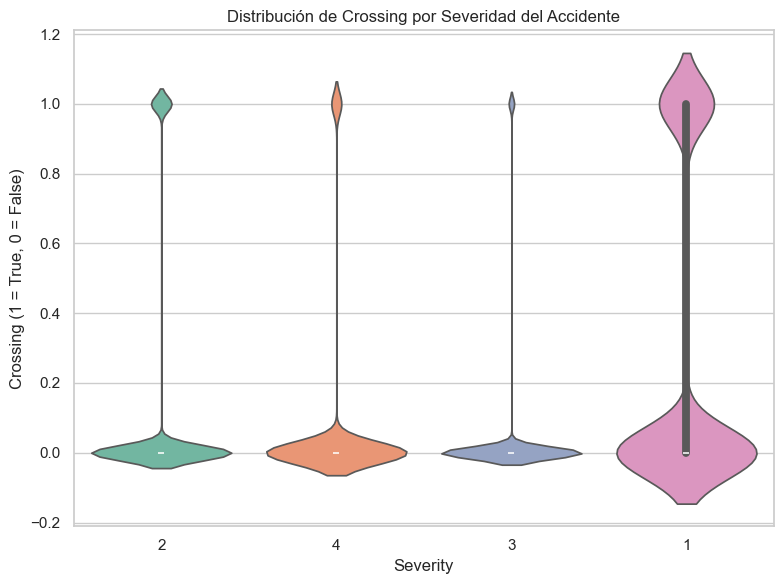

In [ ]:
from elasticsearch import Elasticsearch, helpers
try:
    with Elasticsearch(host) as es:

        query = {
            "_source": ["Severity", "Crossing"],
            "query": {
                "bool": {
                    "must": [
                        {"exists": {"field": "Severity"}},
                        {"exists": {"field": "Crossing"}},
                    ]
                }
            }
        }

        # Obtener todos los documentos
        results = helpers.scan(
            client=es,
            index=index_name,
            query=query,
            preserve_order=False,
            size=5000,
            scroll="2m"
        )

        data = [doc["_source"] for doc in results]
        df = pd.DataFrame(data)

        df.dropna(inplace=True)
        # Asegurar los tipos correctos
        df["Severity"] = df["Severity"].astype(str)  # categoría para seaborn
        df["Crossing"] = df["Crossing"].astype(int)  # True = 1, False = 0


        sns.set(style="whitegrid")

        plt.figure(figsize=(8, 6))
        sns.violinplot(
            x="Severity",
            y="Crossing",
            data=df,
            hue="Severity",
            palette="Set2",
            inner="box",
            legend=False
        )

        plt.title("Distribución de Crossing por Severidad del Accidente")
        plt.xlabel("Severity")
        plt.ylabel("Crossing (1 = True, 0 = False)")
        plt.tight_layout()
        plt.show()


except Exception as e:
    print(f"an error occurred: {e}")

### Diagrama de violin entre junctions (intersecciones) y severity (Severidad)

C:\Users\sebas\AppData\Local\Temp\ipykernel_23688\2355447767.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


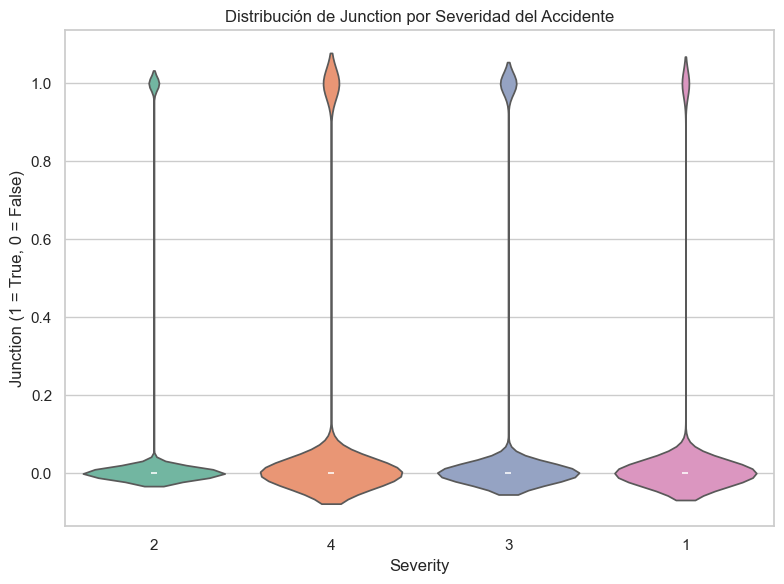

In [ ]:
from elasticsearch import Elasticsearch, helpers
try:
    with Elasticsearch(host) as es:

        query = {
            "_source": ["Severity", "Junction"],
            "query": {
                "bool": {
                    "must": [
                        {"exists": {"field": "Severity"}},
                        {"exists": {"field": "Junction"}}
                    ]
                }
            }
        }

        results = helpers.scan(
            client=es,
            index=index_name,
            query=query,
            preserve_order=False,
            size=5000,
            scroll="2m"
        )

        data = [doc["_source"] for doc in results]
        df = pd.DataFrame(data)

        # Eliminar nulos y asegurar tipos
        df.dropna(inplace=True)
        df["Severity"] = df["Severity"].astype(str)  # Seaborn trata el eje X como categoría
        df["Junction"] = df["Junction"].astype(int)  # False = 0, True = 1

        sns.set(style="whitegrid")

        plt.figure(figsize=(8, 6))
        sns.violinplot(
            x="Severity",
            y="Junction",
            data=df,
            hue="Severity",
            palette="Set2",
            inner="box",
            legend=False
        )

        plt.title("Distribución de Junction por Severidad del Accidente")
        plt.xlabel("Severity")
        plt.ylabel("Junction (1 = True, 0 = False)")
        plt.tight_layout()
        plt.show()

except Exception as e:
    print(f"an error occurred: {e}")

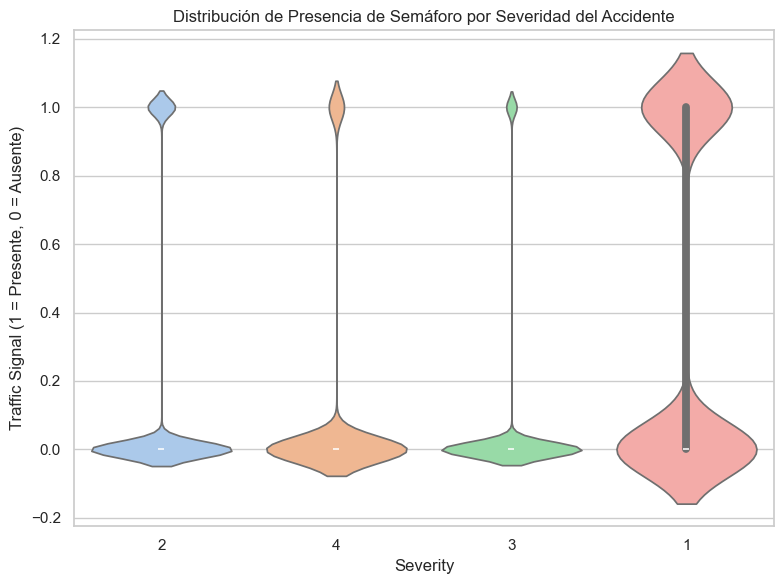

In [ ]:
from elasticsearch import Elasticsearch, helpers
try:
    with Elasticsearch(host) as es:

        query = {
            "_source": ["Severity", "Traffic_Signal"],
            "query": {
                "bool": {
                    "must": [
                        {"exists": {"field": "Severity"}},
                        {"exists": {"field": "Traffic_Signal"}}
                    ]
                }
            }
        }

        results = helpers.scan(
            client=es,
            index=index_name,
            query=query,
            preserve_order=False,
            size=5000,
            scroll="2m"
        )

        data = [doc["_source"] for doc in results]
        df = pd.DataFrame(data)

        df.dropna(inplace=True)
        df["Severity"] = df["Severity"].astype(str)  # para categoría en eje X
        df["Traffic_Signal"] = df["Traffic_Signal"].astype(int)  # True → 1, False → 0

        sns.set(style="whitegrid")

        plt.figure(figsize=(8, 6))
        sns.violinplot(
            x="Severity",
            y="Traffic_Signal",
            data=df,
            hue="Severity",
            palette="pastel",
            inner="box",
            legend=False
        )

        plt.title("Distribución de Presencia de Semáforo por Severidad del Accidente")
        plt.xlabel("Severity")
        plt.ylabel("Traffic Signal (1 = Presente, 0 = Ausente)")
        plt.tight_layout()
        plt.show()

except Exception as e:
    print(f"an error occurred: {e}")

### Diagrama de importancia

C:\Users\sebas\AppData\Local\Temp\ipykernel_33588\611939515.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x="Importance", y="Feature", palette="viridis")


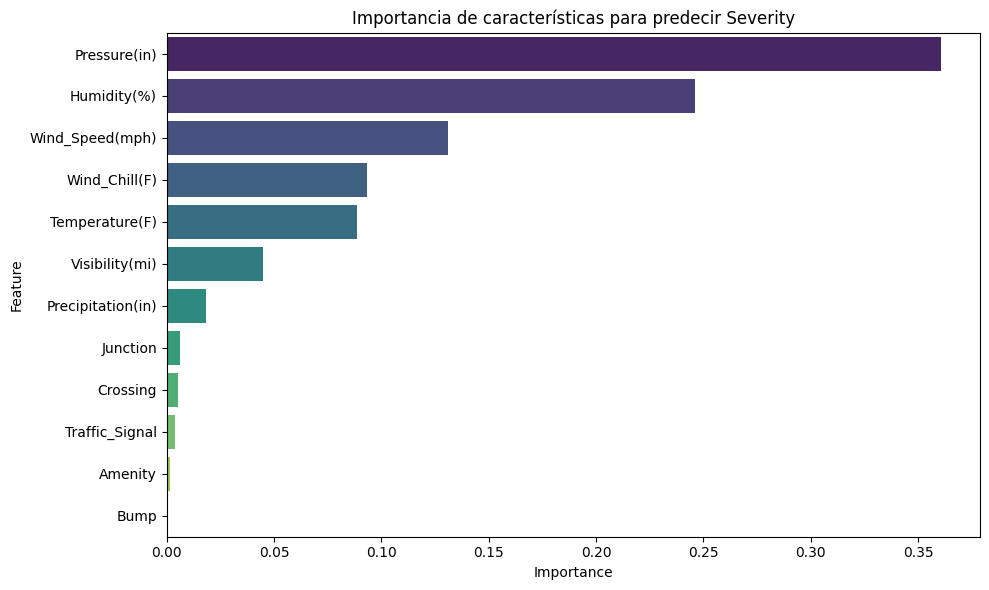

In [ ]:
from elasticsearch import Elasticsearch, helpers
from sklearn.ensemble import RandomForestClassifier
try:
    with Elasticsearch(host) as es:
        
        query = {
            "_source": [
                "Severity",  # Variable objetivo (target) que queremos predecir
                "Temperature(F)", "Wind_Chill(F)", "Humidity(%)", "Pressure(in)",
                "Visibility(mi)", "Wind_Speed(mph)", "Precipitation(in)",  # Variables numéricas
                "Amenity", "Bump", "Crossing", "Junction", "Traffic_Signal"  # Variables booleanas
            ],
            "query": {
                "bool": {
                    "must": [{"exists": {"field": "Severity"}}]  # Asegurarse de que la variable objetivo exista
                }
            }
        }

        # Usar `helpers.scan` para obtener todos los documentos de Elasticsearch
        results = helpers.scan(
            client=es,
            index=index_name,  
            query=query,  
            preserve_order=False,  
            size=5000,  
            scroll="2m"  
        )

        # Convertir los resultados obtenidos en una lista de diccionarios
        data = [doc["_source"] for doc in results]

        # Crear un DataFrame de pandas con los datos obtenidos
        df = pd.DataFrame(data)

        # Limpiar los datos: eliminar valores nulos o codificados como -9999
        for col in [
            "Temperature(F)", "Wind_Chill(F)", "Humidity(%)", "Pressure(in)",
            "Visibility(mi)", "Wind_Speed(mph)", "Precipitation(in)"
            ]: 
            df = df[df[col] > -9000] # -9999 es el valor nulo en el dataset
            
        # Eliminar nulos y convertir booleanos a 0/1
        df.dropna(inplace=True)
        for col in ["Amenity", "Bump", "Crossing", "Junction", "Traffic_Signal"]:
            df[col] = df[col].astype(int)

        
        y = df["Severity"].astype(int)  
        X = df.drop("Severity", axis=1)  

        # Crear un modelo de Random Forest para calcular la importancia de las características
        importances = RandomForestClassifier(
            n_estimators=100,  # Número de árboles en el bosque
            random_state=42,  # Semilla para reproducibilidad
            min_samples_leaf=1,  # Mínimo número de muestras por hoja
            max_features='sqrt'  # Número máximo de características consideradas en cada división
        )
        importances.fit(X, y)  # Entrenar el modelo con las características y la variable objetivo

        # Obtener las importancias de las características
        feature_importance = importances.feature_importances_
        features = X.columns  # Nombres de las características
        # Crear un DataFrame con las características y sus importancias
        importance_df = pd.DataFrame({"Feature": features, "Importance": feature_importance})
        # Ordenar las características por importancia en orden descendente
        importance_df.sort_values(by="Importance", ascending=False, inplace=True)

        # Visualizar las importancias de las características con un gráfico de barras
        plt.figure(figsize=(10, 6))
        sns.barplot(data=importance_df, x="Importance", y="Feature", palette="viridis", hue="Feature", legend=False)
        plt.title("Importancia de características para predecir Severity")  # Título del gráfico
        plt.tight_layout()  # Ajustar el diseño para evitar solapamientos
        plt.show()  # Mostrar el gráfico


except Exception as e:
    print(f"an error occurred: {e}")

### Relación entre Pressure y Severity

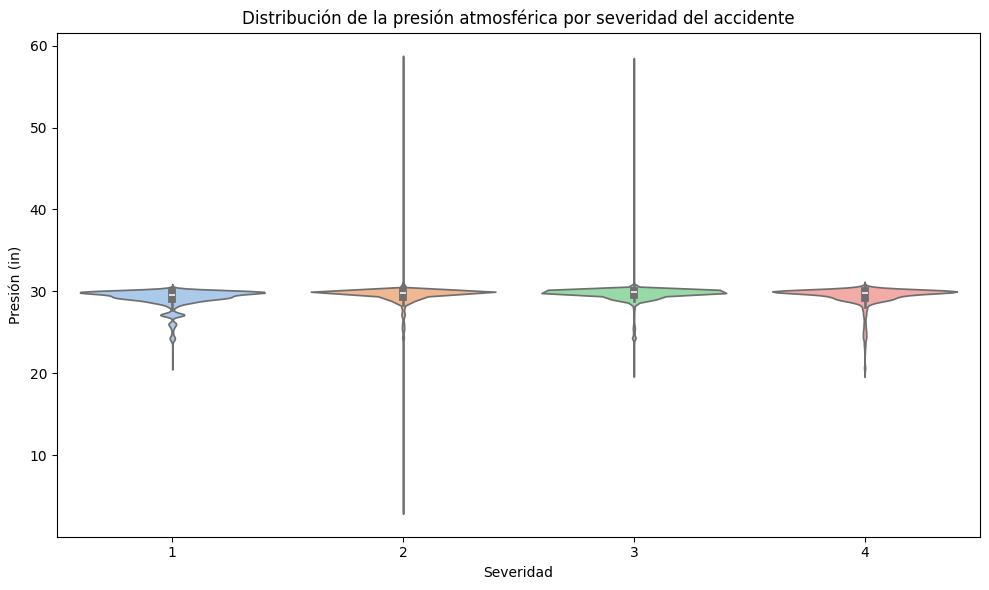

In [ ]:
from elasticsearch import Elasticsearch, helpers
try:
    with Elasticsearch(host) as es:

        query = {
            "_source": ["Severity", "Pressure(in)"],
            "query": {
                "bool": {
                    "must": [
                        {"exists": {"field": "Severity"}},
                        {"exists": {"field": "Pressure(in)"}}
                    ]
                }
            }
        }

        results = helpers.scan(
            client=es,
            query=query,
            index=index_name,
            scroll="2m",
            size=5000
        )

        # Convertir resultados en DataFrame
        data = [doc["_source"] for doc in results]
        df = pd.DataFrame(data)

        df = df[(df["Pressure(in)"] > 0) & (df["Pressure(in)"] < 100)] # & = intersección de conjuntos
        df = df[df["Severity"].notnull()]

        plt.figure(figsize=(10, 6))
        sns.violinplot(
            data=df,
            x="Severity",
            y="Pressure(in)",
            hue="Severity",
            palette="pastel",
            legend=False, 
        )

        plt.title("Distribución de la presión atmosférica por severidad del accidente")
        plt.xlabel("Severidad")
        plt.ylabel("Presión (in)")
        plt.tight_layout()
        plt.show()


except Exception as e:
    print(f"An error occurred: {e}")

## Conclusión del Proyecto

### Propósito del Proyecto
El propósito principal de este proyecto fue analizar un conjunto de datos masivo relacionado con accidentes en los Estados Unidos, con el objetivo de identificar patrones, tendencias y relaciones entre diversas variables. Este análisis busca proporcionar información valiosa que pueda ser utilizada para mejorar la seguridad vial, identificar factores de riesgo y tomar decisiones informadas en la planificación urbana y la gestión del tráfico.

### Procedimiento
El proyecto se desarrolló en varias etapas clave:

1. **Preparación de los Datos**: 
    - Se descargó un conjunto de datos extenso de accidentes en los Estados Unidos.
    - Los datos fueron limpiados y transformados para eliminar columnas irrelevantes, redondear valores y formatear fechas.
    - Se seleccionó una muestra aleatoria de 1,000,000 de registros para facilitar el análisis y se guardó en un archivo JSON.

2. **Diseño del Mapping**:
    - Se diseñó un mapping detallado para ElasticSearch, definiendo los tipos de datos y formatos para cada campo. Esto permitió estructurar los datos de manera eficiente para su almacenamiento y consulta.

3. **Carga de Datos en ElasticSearch**:
    - Se verificó la conexión con el servidor de ElasticSearch.
    - Se cargó el mapping en un índice de ElasticSearch.
    - Los datos fueron cargados en el índice utilizando un enfoque por lotes para manejar el gran volumen de registros.

4. **Análisis de Datos**:
    - Se realizaron consultas a ElasticSearch para extraer información relevante.
    - Los datos fueron visualizados mediante gráficos como histogramas, diagramas de violín, mapas de calor y gráficos de barras.
    - Se exploraron relaciones entre variables como severidad, condiciones climáticas, visibilidad, presión atmosférica y la presencia de amenidades o intersecciones.

### Razón de Utilizar ElasticSearch
ElasticSearch fue elegido como la herramienta principal para almacenar y consultar los datos debido a varias razones:

- **Escalabilidad**: ElasticSearch es capaz de manejar grandes volúmenes de datos de manera eficiente, lo cual es esencial para este proyecto debido al tamaño del conjunto de datos.
- **Velocidad**: Las consultas en ElasticSearch son rápidas, incluso cuando se trata de datos masivos, lo que permite realizar análisis en tiempo real.
- **Flexibilidad**: ElasticSearch permite realizar consultas complejas y personalizadas, como agregaciones y filtros, que son fundamentales para el análisis de datos.
- **Integración**: ElasticSearch se integra fácilmente con herramientas de visualización y análisis, lo que facilita la creación de gráficos y reportes.

### Conclusión de los Datos
El análisis de los datos proporcionó varias conclusiones interesantes:

1. **Distribución Geográfica**:
    - Los accidentes se concentran en áreas urbanas y en regiones con alta densidad de población.
    - El mapa de calor mostró patrones claros de concentración en ciertas áreas, lo que puede estar relacionado con la infraestructura vial y el volumen de tráfico.

2. **Factores Climáticos**:
    - Aunque se podría esperar que las condiciones climáticas adversas aumenten la probabilidad de accidentes, los datos mostraron que la mayoría de los accidentes ocurrieron en condiciones climáticas "Fair" (soleado o despejado). Esto sugiere que otros factores, como el comportamiento del conductor, pueden ser más determinantes.

3. **Severidad de los Accidentes**:
    - La mayoría de los accidentes fueron de severidad baja o moderada, pero se identificaron patrones en la relación entre la severidad y variables como la visibilidad, la presión atmosférica y la presencia de amenidades.

4. **Infraestructura Vial**:
    - Variables como la presencia de cruces, intersecciones y semáforos mostraron correlaciones con la severidad de los accidentes. Esto resalta la importancia de la planificación urbana y la infraestructura vial en la prevención de accidentes.

5. **Importancia de las Variables**:
    - El análisis de importancia de características utilizando un modelo de Random Forest destacó que variables como la visibilidad, la presión atmosférica y la presencia de amenidades tienen un impacto significativo en la severidad de los accidentes.

### Reflexión Final
Este proyecto demostró cómo el análisis de grandes volúmenes de datos puede proporcionar información valiosa para abordar problemas complejos como la seguridad vial. ElasticSearch se destacó como una herramienta poderosa para manejar y analizar datos masivos, permitiendo realizar consultas rápidas y obtener insights significativos. Los resultados obtenidos pueden servir como base para futuras investigaciones y para la implementación de políticas y estrategias que mejoren la seguridad en las carreteras.